In [1]:
import cantata
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from box import Box
from cantata.plotting import output as cp
from cantata import cfg

In [2]:
%load_ext autoreload
%autoreload 1
%aimport cantata, cantata.plotting.output

In [3]:
figsize = (14,5)

In [4]:
print(cfg.model_config)

1tier.yaml


In [5]:
# Extract populations & projections:
populations = Box()
drivers = Box()
targets = Box()
for name, pop in cfg.model.populations.items():
    p = pop.copy()
    targets[name] = p.targets
    del p.targets
    if p.rate >= 0:
        drivers[name] = p
    else:
        populations[name] = p

In [6]:
for name in drivers.keys():
    assert np.all([name not in t for t in targets.values()]), name

In [7]:
base_cfg = cfg.copy()
del base_cfg.model_config
base_cfg.model.populations = Box()

In [8]:
second = int(1/base_cfg.time_step)

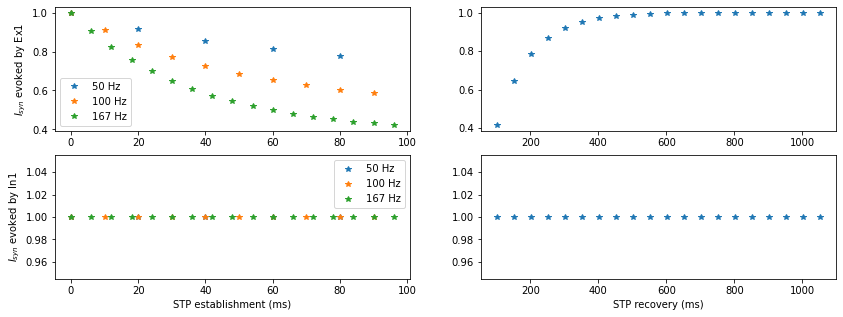

In [9]:
# STP sanity check
establish_end = 100

# To probe establishment - final value is used for recovery:
est_steps = [20,10,6] # Establishment ISIs, ms
est_ms = [torch.arange(establish_end/s) * s for s in est_steps]

# To probe recovery:
rec_steps = 20 # Number of recovery probes
recover_step = 50 # Spacing between recovery probes, ms
establish_step = est_steps[-1]
establish_ms = torch.arange(0,establish_end,establish_step)
recover_ms = torch.arange(rec_steps)*recover_step + establish_ms[-1] + est_steps[-1]

ms_to_idx = lambda ms: (ms/(1000*base_cfg.time_step)).to(torch.long)
establish_idx = ms_to_idx(establish_ms)
recover_idx = ms_to_idx(recover_ms)
est_idx = [ms_to_idx(est) for est in est_ms]

stp_cfg = base_cfg.copy()
stp_cfg.batch_size = rec_steps + len(est_steps)
stp_cfg.n_inputs = 1
stp_cfg.n_steps = recover_idx[-1] + 3
stp_cfg.model.populations.Driver = Box(dict(rate=0, targets=dict(Probe={})))
stp_cfg.model.populations.Output = Box({})

inputs = torch.zeros(stp_cfg.batch_size, stp_cfg.n_steps, stp_cfg.n_inputs, **stp_cfg.tspec)
surefire = 1/stp_cfg.time_step
inputs[:rec_steps, establish_idx, :] = surefire
inputs[torch.arange(rec_steps), recover_idx, :] = surefire

for i,idx in enumerate(est_idx):
    inputs[rec_steps + i, idx, :] = surefire

plt.figure(figsize=figsize)
for i, (name, pop) in enumerate(populations.items()):
    stp_cfg.model.populations.Probe = pop.copy()
    stp_cfg.model.populations.Probe.n = 1
    stp_cfg.model.populations.Probe.noise_N = 0
    stp_cfg.model.populations.Probe.targets = Box(dict(Output={}))
    cantata.config.load(stp_cfg)
    m = cantata.Module()
    with torch.no_grad():
        state,epoch,record = m.forward_init(inputs, ['syn'])
        epoch.W[0,2] = 1 # Driver to Probe
        epoch.W[2,1] = 1 # Probe to Output
        m.forward_run(state,epoch,record)
        m.forward_close(record)
    
    plt.subplot(2,len(populations),2*i+1)
    for j,idx in enumerate(est_idx):
        plt.plot(est_ms[j], record.syn[rec_steps+j, idx+2, 1].cpu().numpy(), '*',
                 label=f'{1/(cfg.time_step * est_steps[j]):.0f} Hz')
    plt.legend()
    if i==len(populations)-1:
        plt.xlabel('STP establishment (ms)')
    plt.ylabel(f'$I_{{syn}}$ evoked by {name}')
    
    plt.subplot(2,len(populations),2*i+2)
    plt.plot(recover_ms, record.syn[torch.arange(rec_steps),recover_idx+2,1].cpu().numpy(), '*')
    if i==len(populations)-1:
        plt.xlabel('STP recovery (ms)')